<a href="https://colab.research.google.com/github/jaejunchoe/HAIDS-Lab/blob/main/Upload_DeepCoNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비준비

In [ ]:
## 1번 실행 -> 런타임 다시 시작 -> 2번 실행 -> 3번 실행 -> 시작 실행

## 1번

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,220 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and dire

In [ ]:
## 2번

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

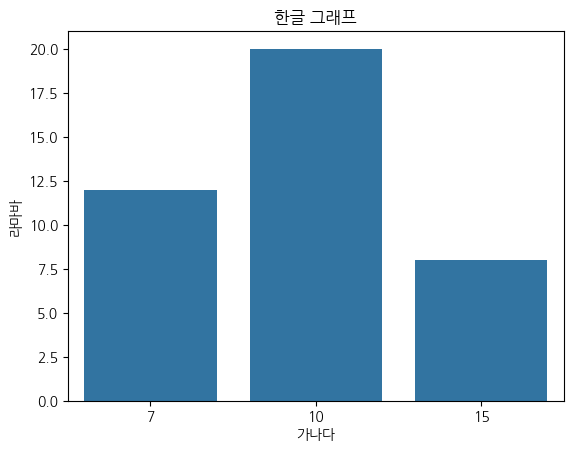

In [ ]:
## 3번

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 나눔고딕 폰트 경로 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)

# 그래프 그리기 예시
data = {'가나다': [10, 15, 7], '라마바': [20, 8, 12]}
df = pd.DataFrame(data)
sns.barplot(data=df, x='가나다', y='라마바')
plt.title('한글 그래프')
plt.show()


# 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

# 데이터 불러오기

In [ ]:
# 데이터 불러오기
df = pd.read_excel('/content/drive/MyDrive/IDS/amaxon reviews 2023/dataset/processing_Subscription Boxes_Reviews_ver01.xlsx')
data = df[['rating', 'text', 'parent_asin', 'user_id']]
data = data.dropna()

texts = data['text'].values
ratings = data['rating'].values
items = data['parent_asin'].values
users = data['user_id'].values



# 2.3 Word Representation

**Tokenizer (논문에서는 평균 150개 미만이라고만 명시)**

In [ ]:
# 텍스트 데이터를 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
max_sequence_length = 300  # 최대 단어의 수(논문에서는 평균 150개 미만이라 나와있어서 300으로 임의로 설정)
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

**사전학습된 Glove 50차원 (논문에서는 300차원 Word2Vec)**

In [ ]:
# Glove 임베딩 로드
def load_glove_embeddings(glove_path, word_index, embedding_dim=50):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_dim = 50
glove_path = '/content/drive/MyDrive/IDS/amaxon reviews 2023/glove.6B.50d.txt'
embedding_matrix = load_glove_embeddings(glove_path, word_index, embedding_dim)

# Label Encoder와 Data split(8:1:1)





In [ ]:
# 아이템 및 사용자 데이터 전처리
from sklearn.preprocessing import LabelEncoder
item_encoder = LabelEncoder()
user_encoder = LabelEncoder()
item_encoded = item_encoder.fit_transform(items)
user_encoded = user_encoder.fit_transform(users)

# 데이터 분할 (train:val:test = 8:1:1)
X_text_train, X_text_temp, X_item_train, X_item_temp, y_train, y_temp = train_test_split(
    data_padded, item_encoded, ratings, test_size=0.2, random_state=42)

X_text_val, X_text_test, X_item_val, X_item_test, y_val, y_test = train_test_split(
    X_text_temp, X_item_temp, y_temp, test_size=0.5, random_state=42)

# 2.4 CNN Layers (DeepCoNN 구조)

In [ ]:
# 하이퍼파라미터 설정
conv_filters = 100      # Kernel (filter) 개수
kernel_size = 3         # Window size
dropout_rate = 0.5      # Dropout
dense_units = 50        # Latent Features(User와 Item 각각 50차원)
learning_rate = 0.002   # Learning_rate(학습률)

# 사용자 신경망 (Netu)
user_input = Input(shape=(max_sequence_length,), name='user_input')
user_embedding = Embedding(input_dim=len(word_index) + 1,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           trainable=False)(user_input)  # input_length 제거
user_conv = Conv1D(conv_filters, kernel_size, activation='relu')(user_embedding)    # activation = relu
user_pooling = MaxPooling1D(pool_size=2)(user_conv)
user_flatten = Flatten()(user_pooling)
user_dense = Dense(dense_units, activation='relu')(user_flatten)                    # = Fully connected layer, activation = relu
user_dropout = Dropout(dropout_rate)(user_dense)

# 아이템 신경망 (Neti)
item_input = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=len(item_encoder.classes_), output_dim=embedding_dim)(item_input)  # input_length 제거
item_flatten = Flatten()(item_embedding)
item_dense = Dense(dense_units, activation='relu')(item_flatten)                    # = Fully connected layer, activation = relu
item_dropout = Dropout(dropout_rate)(item_dense)






# 2.5 Shared Layer

In [ ]:
# 두 신경망 결합 (Factorization Machine 적용)
concat = Concatenate()([user_dropout, item_dropout])

# Factorization Machine 상호작용 계산 함수 (차원 확장 없이 2차원 반환 유지)
def fm_interaction(x):
    sum_square = tf.square(tf.reduce_sum(x, axis=1, keepdims=True))  # 차원 별 합의 제곱
    square_sum = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)  # 각 차원 제곱 후 합
    interaction = 0.5 * (sum_square - square_sum)  # 상호작용 계산
    return interaction  # 2차원 반환 유지


# Lambda 레이어로 Factorization Machine 적용
interaction = Lambda(fm_interaction)(concat)

# Dense 레이어 적용
output = Dense(1, activation='linear')(interaction)




**'activation = linear로 설정한 이유'**

-> output이라는 변수는 사용자 신경망 (Netu)와 아이템 신경망 (Neti)이 결합되어 최종적으로 평점을 예측하는 것이다. 따라서, 이는 회귀 문제(rating prediction)이라고 판단했다. 결국 최종출력은 실수의 형태로 나와야한다는 것을 의미하기에 예측된 연속적인 범위의 평점값을 그대로 도출하기 위해서 사용했다.


(보통은 sigmoid, softmax, relu 등등이 있지만 이것은 압축하거나 확률분포로 반환하는 등의 변형요소가 존재하기에 부적합)

# 2.6 Network Training

In [ ]:
from tensorflow.keras.optimizers import Adam

#optimizer(opt = Adam)
opt = Adam(learning_rate=learning_rate)     # 논문에서는 optimizer = RMSprop.

# 모델 컴파일
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

# 모델 학습
history = model.fit([X_text_train, X_item_train], y_train,
                    validation_data=([X_text_val, X_item_val], y_val),
                    batch_size=128, epochs=50)                                  # batch_size와 epoch(반복횟수)




Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 300, 50)        │        943,350 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 298, 100)       │         15,100 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 149, 100)       │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 1, 50)          │         32,050 │ item_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 14900)          │              0 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 50)             │              0 │ embedding_11[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 50)             │        745,050 │ flatten_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 50)             │          2,550 │ flatten_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 50)             │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 50)             │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11            │ (None, 100)            │              0 │ dropout_10[0][0],      │
│ (Concatenate)             │                        │                │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_10 (Lambda)        │ (None, 1)              │              0 │ concatenate_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 1)              │              2 │ lambda_10[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,738,102 (6.63 MB)

 Trainable params: 794,752 (3.03 MB)

 Non-trainable params: 943,350 (3.60 MB)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2.1957 - mae: 1.2798 - val_loss: 2.2573 - val_mae: 1.3238
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2125 - mae: 1.2908 - val_loss: 2.2722 - val_mae: 1.3406
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1855 - mae: 1.2820 - val_loss: 2.2539 - val_mae: 1.3134
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1272 - mae: 1.2567 - val_loss: 2.2574 - val_mae: 1.3207
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1593 - mae: 1.2687 - val_loss: 2.2483 - val_mae: 1.2841
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2061 - mae: 1.2863 - val_loss: 2.2601 - val_mae: 1.2633
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1662 - mae: 1.2635 - val_loss: 2.2519 - val_mae: 1.2939
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2009 - mae: 1.2837 - val_loss: 2.2564 - val_mae: 1.3146
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

# 최종 결과값

**Test Data에 대한 최종 결과값 (mse, mae 순서)**

In [ ]:
import matplotlib.pyplot as plt


# 평가
test_loss, test_mae = model.evaluate([X_text_test, X_item_test], y_test)




51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2955 - mae: 1.3116


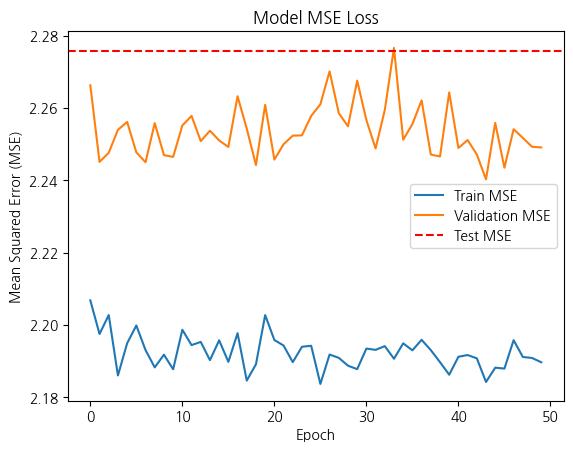

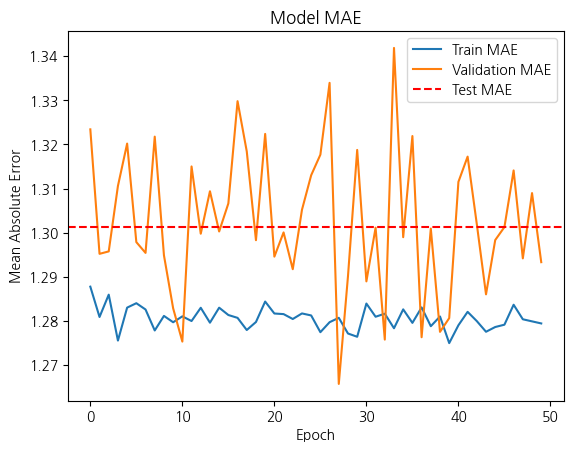

In [ ]:
# 학습 손실(MSE) 및 검증 손실(MSE)을 플롯으로 시각화
def plot_history(history, test_loss=None, test_mae=None):
    # Loss (MSE)
    plt.figure()
    plt.plot(history.history['loss'], label='Train MSE')
    plt.plot(history.history['val_loss'], label='Validation MSE')
    if test_loss is not None:
        plt.axhline(y=test_loss, color='r', linestyle='--', label='Test MSE')
    plt.title('Model MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.show()

    # MAE (평가지표)
    plt.figure()
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    if test_mae is not None:
        plt.axhline(y=test_mae, color='r', linestyle='--', label='Test MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

# 학습 기록(history) 및 테스트 결과 시각화
plot_history(history, test_loss=test_loss, test_mae=test_mae)